In [3]:
import sys
import os
import importlib

parent = os.path.dirname(os.getcwd())
sys.path.insert(0, parent)

import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize


from Helpers import loadData, multiplot, sphereMask, dataSizes
importlib.reload(sys.modules['Helpers.sphereMask'])
importlib.reload(sys.modules['Helpers.dataSizes'])
importlib.reload(sys.modules['Helpers'])

<module 'Helpers' from '/home/snow/Coding/Granular-Compression/Identification/Helpers/__init__.py'>

In [4]:
folderData = os.path.join(os.path.dirname(parent),'Data')
data = loadData(location=folderData, fileName='downscale_17.hdf5')

In [56]:
with h5py.File(rf'{folderData}/Scan_17.hdf5','r') as f: 
    legData = f['RawData/Scan_17'][:] # (slices, rows, width)

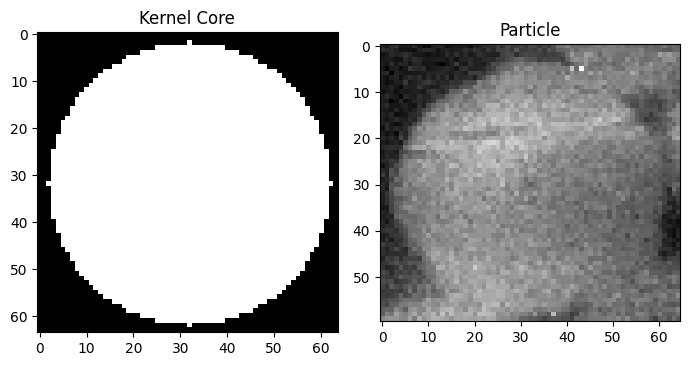

In [5]:
kernel = sphereMask(diameter=100,pad=2,scale=.6)
particle = data[90:150,35:100,25]

_,__,c= kernel.shape
core = kernel[:,:,int(c/2)]

multiplot(core,particle,ax_vis=True,titles=['Kernel Core','Particle'])

In [6]:
from skimage.feature import canny, peak_local_max
from scipy.signal import fftconvolve
import pandas as pd
#import nvmath

In [ ]:
a,b,c = legData.shape
cat = legData[0:int(a/2),0:int(b/1.5),0:int(c/2)]
dataSizes(globals().items())

,Mb,Gb
legData,20884,20.4
chiMap,10442,10.2
invChi,10442,10.2
cat,3481,3.4
data,220,0.2
kernel,2,0.0
core,0,0.0
particle,0,0.0
obj,0,0.0


In [142]:
chiMap = fftconvolve(cat,kernel,mode='same')
invChi = 1/(chiMap+1e-12)

In [ ]:
chiMap = fftconvolve(data,kernel,mode='full')
invChi = 1/(chiMap+1e-12)

In [ ]:
coords = peak_local_max(data, min_distance=int(MinSep), threshold_abs=CutOff)

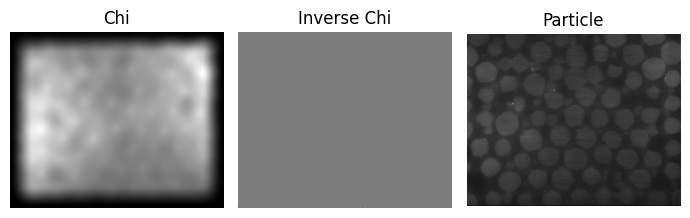

In [ ]:
multiplot(chiMap[:,:,50],50*invChi[:,:,50],data[:,:,50],titles=['Chi','Inverse Chi', 'Particle'])

In [ ]:
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
def convolution3D_FFTdomain(img, kernel): 
    return fftconvolve(img, kernel, mode='same')

def chiimg3D_FFT(img, ip, W=None, Wip2=None):
    if W is None: 
        W = ip
    if Wip2 is None: 
        Wip2 = convolution3D_FFTdomain(np.ones_like(img), ip**2 * W)
    return 1 + (-2*convolution3D_FFTdomain(img, ip*W) + convolution3D_FFTdomain(img**2, W))/Wip2, Wip2



def findpeaks3D(img, CutOff=0, MinSep=1):
    coords = peak_local_max(img, min_distance=int(MinSep), threshold_abs=CutOff)
    spx, spy, spz = coords[:, 2], coords[:, 1], coords[:, 0]  # XYZ
    return len(spx), spx, spy, spz
